# Exploratory Data Analysis 1: <br><br> Concordance of Thyroid Hormone Receptor Activity in Rats and Humans

In the preclinical stage of drug development, drug candidates are tested against in non-human species.  One of the commonly used animals in the preclinical stage is rodents (e.g., mice and rats).  
The underlying assumption here is that the bioactivity (e.g., toxicity and efficacy) of a drug candidate in animals is similar to its activity in humans.  

In this notebook, we will look into the validity of this assumption by comparing the bioactivity data available in PubChem for human and rat thyroid hormone receptor.

Let's import necessary libraries.

In [2]:
#% pip install seaborn, scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
from scipy.stats import linregress
#import time
#import json

## Checking the amount of available data

This section focuses on assessing the availability of the bioactivity data for the thyroid hormone receptor in both human and rat models.  The data sets were downloaded (in August 2025) from the PubChem Protein summary pages for protein assesions  `NP_001257783` (rats) and `P10828` (humans).

- `NP_001257783` (rats)  
    https://pubchem.ncbi.nlm.nih.gov/protein/NP_001257783#section=Chemicals-and-Bioactivities  
- `P10828` (humans)  
    https://pubchem.ncbi.nlm.nih.gov/protein/P10828#section=Chemicals-and-Bioactivities  

Similar data can be downloaded through the PUG REST endpoint in the next block

In [3]:
import io, time, requests, pandas as pd

BASE = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"
HEADERS = {"User-Agent": "pubchem-bioactivity/1.2 (+notebook)"}

GENE_SYMBOL = "THRB"       # thyroid hormone receptor beta
ACCESSION   = "P10828"     # UniProt (human)
ONLY_HUMAN  = True
CHUNK       = 120          # AID chunk size for fallback path

def _get(url, timeout=90):
    r = requests.get(url, headers=HEADERS, timeout=timeout)
    r.raise_for_status()
    return r

def _read_csv_text(txt):
    return pd.read_csv(io.StringIO(txt), comment="#", low_memory=False)

def fetch_concise_by_gene_symbol(symbol: str) -> pd.DataFrame:
    url = f"{BASE}/assay/target/genesymbol/{symbol}/concise/CSV"
    return _read_csv_text(_get(url).text)

def get_aids_for_accession(acc: str):
    url = f"{BASE}/assay/target/accession/{acc}/aids/JSON"
    j = _get(url).json()
    aids = []
    stack = [j]
    while stack:
        x = stack.pop()
        if isinstance(x, dict):
            for k,v in x.items():
                if k.lower() in ("aid","aids","aidlist"):
                    if isinstance(v, list):
                        aids.extend(int(t) for t in v if str(t).isdigit())
                    elif isinstance(v, (int,str)) and str(v).isdigit():
                        aids.append(int(v))
                else:
                    stack.append(v)
        elif isinstance(x, list):
            stack.extend(x)
    return sorted(set(aids))

def fetch_concise_for_aids(aids, chunk=100):
    out = []
    for i in range(0, len(aids), chunk):
        sl = aids[i:i+chunk]
        url = f"{BASE}/assay/aid/{','.join(map(str, sl))}/concise/CSV"
        time.sleep(0.2)
        out.append(_read_csv_text(_get(url, timeout=120).text))
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()

def normalize(df: pd.DataFrame) -> pd.DataFrame:
    # rename a few common columns for easier filtering
    rename = {
        "Target TaxID": "target_taxid",
        "Target Organism": "target_organism",
        "Target Protein Accession": "target_protein_accession",
        "Target GeneID": "target_geneid",
        "Outcome": "activity_outcome",
        "Activity": "activity_type",
        "Activity_Value": "activity_value",
        "Activity_Unit": "activity_unit",
        "Assay Type": "assay_type",
        "AID Name": "aid_name",
    }
    for k,v in rename.items():
        if k in df.columns: df = df.rename(columns={k:v})
    # helpful boolean
    if "activity_outcome" in df.columns:
        df["is_active"] = df["activity_outcome"].astype(str).str.lower().eq("active")
    return df

def filter_human_and_accession(df: pd.DataFrame, accession: str, only_human=True) -> pd.DataFrame:
    out = df.copy()
    if only_human:
        if "target_taxid" in out.columns:
            out = out[pd.to_numeric(out["target_taxid"], errors="coerce").eq(9606)]
        elif "target_organism" in out.columns:
            out = out[out["target_organism"].astype(str).str.contains("Homo sapiens", case=False, na=False)]
    # narrow to the accession when present (ignore version suffixes)
    if "target_protein_accession" in out.columns:
        pat = rf"^{accession}(?:\.\d+)?$"
        mask = out["target_protein_accession"].astype(str).str.upper().str.match(pat, case=False, na=False)
        if mask.any():
            out = out[mask]
    return out.reset_index(drop=True)

try:
    df = fetch_concise_by_gene_symbol(GENE_SYMBOL)
    df = normalize(df)
    df = filter_human_and_accession(df, ACCESSION, only_human=ONLY_HUMAN)
    gene_ok = not df.empty
except Exception:
    gene_ok = False
    df = pd.DataFrame()

# --- fallback: accession → AIDs → concise (slower, but exact) ---
if not gene_ok:
    aids = get_aids_for_accession(ACCESSION)
    if not aids:
        raise SystemExit(f"No AIDs found for accession {ACCESSION}.")
    df = fetch_concise_for_aids(aids, chunk=CHUNK)
    df = normalize(df)
    df = filter_human_and_accession(df, ACCESSION, only_human=ONLY_HUMAN)

df = df.drop_duplicates().reset_index(drop=True)
df.to_csv((os.path.join('data','pubchem_bioactivity_P10828_THRB.csv')), index=False)
print(f"Wrote {len(df):,} rows → pubchem_bioactivity_P10828_THRB.csv")
display(df.head(12))


Wrote 1,195,151 rows → pubchem_bioactivity_P10828_THRB.csv


,AID,SID,CID,Activity Outcome,Target Accession,target_geneid,Activity Value [uM],Activity Name,Assay Name,assay_type,PubMed ID,RNAi
0,1469,842123,6602616.0,Inactive,NP_001121649,7068.0,NaN,Potency,qHTS for Inhibitors of the Interaction of Thyr...,Confirmatory,NaN,NaN
1,1469,842124,644371.0,Inactive,NP_001121649,7068.0,NaN,Potency,qHTS for Inhibitors of the Interaction of Thyr...,Confirmatory,NaN,NaN
2,1469,842131,6602565.0,Inconclusive,NP_001121649,7068.0,100.0,Potency,qHTS for Inhibitors of the Interaction of Thyr...,Confirmatory,NaN,NaN
3,1469,842133,644388.0,Inactive,NP_001121649,7068.0,NaN,Potency,qHTS for Inhibitors of the Interaction of Thyr...,Confirmatory,NaN,NaN
4,1469,842134,644390.0,Inactive,NP_001121649,7068.0,NaN,Potency,qHTS for Inhibitors of the Interaction of Thyr...,Confirmatory,NaN,NaN
5,1469,842139,644395.0,Inactive,NP_001121649,7068.0,NaN,Potency,qHTS for Inhibitors of the Interaction of Thyr...,Confirmatory,NaN,NaN
6,1469,842147,644403.0,Inactive,NP_001121649,7068.0,NaN,Potency,qHTS for Inhibitors of the Interaction of Thyr...,Confirmatory,NaN,NaN
7,1469,842150,644406.0,Inactive,NP_001121649,7068.0,NaN,Potency,qHTS for Inhibitors of the Interaction of Thyr...,Confirmatory,NaN,NaN
8,1469,842155,644411.0,Inactive,NP_001121649,7068.0,NaN,Potency,qHTS for Inhibitors of the Interaction of Thyr...,Confirmatory,NaN,NaN
9,1469,842163,644419.0,Inactive,NP_001121649,7068.0,NaN,Potency,qHTS for Inhibitors of the Interaction of Thyr...,Confirmatory,NaN,NaN


### Loading data for rat thyroid hormone receptor

The following cells load and provide an initial exploration of the bioactivity data for the **rat thyroid hormone receptor**.

This cell defines the data type for the "COMPOUND_CID" column to ensure accurate data loading and to prevent memory-related issues.

In [7]:
mydtype = {"Compound_CID" : "Int64"}
#mydtype = {"Compound_CID" : "Int64", "pmid":"Int64", "taxid":"object", "targettaxid":"object"}

Now read a CSV file containing bioactivity data for the rat thyroid hormone receptorinto a pandas DataFrame and then displays the dimensions of the DataFrame.

In [11]:
df_rat = pd.read_csv(os.path.join('data','pubchem_protacxn_NP_001257783_bioactivity_protein.zip'), compression='zip', dtype=mydtype,low_memory=False)
df_rat.shape

(31458, 32)

Display a first few rows of the rat bioactivity DataFrame to get a quick overview of the data's structure and content.

In [12]:
df_rat.head()

,Bioactivity_ID,Activity,BioAssay_AID,Substance_SID,Compound_CID,refsid,Gene_ID,PMID,Aid_Type,Last_Modified_Date,...,Representative_Protein_Accession,Taxonomy_ID,Cell_ID,Target_Taxonomy_ID,Anatomy_ID,Anatomy,dois,pmcids,pclids,citations
0,394010671,Active,743066,144203580,5920,NaN,24831,NaN,Confirmatory,20140820,...,NP_001257783,10116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,394011094,Active,743066,144204055,92044441,NaN,24831,NaN,Confirmatory,20140820,...,NP_001257783,10116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,394011748,Active,743066,144203868,5803,NaN,24831,NaN,Confirmatory,20140820,...,NP_001257783,10116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,394012257,Active,743066,144204363,444795,NaN,24831,NaN,Confirmatory,20140820,...,NP_001257783,10116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,394012468,Active,743066,144204799,57333099,NaN,24831,NaN,Confirmatory,20140820,...,NP_001257783,10116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# df_rat.columns    # Uncomment to check the column names.

### Loading data for human thyroid hormone receptor

Now read a CSV file containing bioactivity data for the **human** thyroid hormone receptor into a pandas DataFrame, called `df_human`, and then displays the dimensions of the DataFrame.

In [16]:
# Write your code here
df_human = pd.read_csv(os.path.join('data','pubchem_protacxn_P10828_bioactivity_protein.zip'), compression='zip', dtype=mydtype,low_memory=False)
df_human.shape

(573448, 32)

Displays a first few rows of the new data frame.

In [17]:
# Write your code here
df_human.head()

,Bioactivity_ID,Activity,BioAssay_AID,Substance_SID,Compound_CID,refsid,Gene_ID,PMID,Aid_Type,Last_Modified_Date,...,Representative_Protein_Accession,Taxonomy_ID,Cell_ID,Target_Taxonomy_ID,Anatomy_ID,Anatomy,dois,pmcids,pclids,citations
0,88338908,Probe,2512,87550851,5184800,NaN,7068.0,NaN,Summary,20110303,...,P10828,9606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44621591,Active,1469,26756872,312145,NaN,7068.0,NaN,Confirmatory,20081231,...,P10828,9606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44622194,Active,1469,26757448,13297,NaN,7068.0,NaN,Confirmatory,20081231,...,P10828,9606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44622400,Active,1469,29215483,3856851,NaN,7068.0,NaN,Confirmatory,20081231,...,P10828,9606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,44622529,Active,1469,29215388,4139,NaN,7068.0,NaN,Confirmatory,20081231,...,P10828,9606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#df_human.columns    # Uncomment to check the column names.

### Checking the amount of available data

Here, we compare the types of bioactivity data available for both rat and human thyroid hormone receptors.

This cell counts the occurrences of each unique value in the 'Activity_Type' column of the rat bioactivity DataFrame.

In [18]:
df_rat['Activity_Type'].value_counts(dropna=False)

Activity_Type
Potency    31458
Name: count, dtype: int64

Now get the occurrences of each unique value in the 'Activity_Type' column of the human bioactivity DataFrame.

In [19]:
# Write your own code here
df_human['Activity_Type'].value_counts(dropna=False)

Activity_Type
Potency          571735
IC50                812
NaN                 399
EC50                316
Ki                  140
Kd                   37
Activity              7
Concentration         1
XC50                  1
Name: count, dtype: int64

To compare the small-molecule bioactivity between rats and humans, we need to use the same activity measures.  The rat data set has only the potency values, while the human data has other types of activities (e.g., EC50, IC50, Ki, Kd, ...).  Because the potency is the only activity type available for **both** species, we will use the potency data for comparison.

### Checking the available bioassays

This section identifies the unique bioassays in which the rat and human thyroid hormone receptor were targeted.

First, let's get the number of unique AIDs for rat thyroid hormone receptor.

In [20]:
df_rat['BioAssay_AID'].nunique()

3

Let's get the number of data points for rat thyroid hormone receptor.

In [21]:
df_rat['BioAssay_AID'].value_counts()

BioAssay_AID
743066    10486
743065    10486
743067    10486
Name: count, dtype: int64

Now check the number of unique assays and the number of data points for each unique assay for human thyroid hormone receptor.

In [22]:
# Write your own code
df_human['BioAssay_AID'].nunique()


176

In [23]:
# Write your own code
df_human['BioAssay_AID'].value_counts()


BioAssay_AID
1479       282587
1469       282587
588547       2858
588545       2858
425882        147
            ...  
260888          1
1192350         1
1192365         1
504934          1
1192366         1
Name: count, Length: 176, dtype: int64

There are more than one hundred assays for human thyroid hormone receptor. However, we are interested in the assays with the **potency** values, because only the potency data is available for both rats and humans.  Therefore, let's focus on them.

In [24]:
df_rat[ df_rat['Activity_Type'] == 'Potency'][['BioAssay_AID', 'BioAssay_Name']].value_counts()

BioAssay_AID  BioAssay_Name                                                                                            
743065        qHTS assay to identify small molecule antagonists of the thyroid receptor (TR) signaling pathway             10486
743066        qHTS assay to identify small molecule agonists of the thyroid receptor (TR) signaling pathway                10486
743067        qHTS assay to identify small molecule antagonists of the thyroid receptor (TR) signaling pathway: Summary    10486
Name: count, dtype: int64

In [25]:
df_human[ df_human['Activity_Type'] == 'Potency'][['BioAssay_AID', 'BioAssay_Name']].value_counts()

BioAssay_AID  BioAssay_Name                                                                                                                                                          
1469          qHTS for Inhibitors of the Interaction of Thyroid Hormone Receptor and Steroid Receptor Coregulator 2                                                                      282587
1479          Total Fluorescence Counterscreen for Inhibitors of the Interaction of Thyroid Hormone Receptor and Steroid Receptor Coregulator 2                                          282587
588545        qHTS assay for small molecule agonists of thyroid hormone receptor beta signaling                                                                                            2858
588547        qHTS assay for small molecule antagonists of thyroid hormone receptor beta signaling                                                                                         2858
1570          Concentration Response Confirmation 

Considering the title and the data point counts for the returned assays, the three assays for rat thyroid hormone receptor are high-throughput screening (HTS) assays.  Therefore, we also need HTS assays for human thyroid hormone receptor.  

In the remaining part of this notebook, we will use the qHTS assays for antagonists of rat and human thyroid hormone receptors.  

- [**AID 743065**](https://pubchem.ncbi.nlm.nih.gov/bioassay/743065): Confirmatory Assay (Antagonists)  
- [**AID 588547**](https://pubchem.ncbi.nlm.nih.gov/bioassay/588547): Confirmatory (antagonists)  

They were chosen based on the following considerations.  
- The four assays for human thyroid hormone receptors with more than 1000 data points (i.e., 1469, 1479, 588547, 588545) are HTS screening.    
- Strictly speaking, AIDs 1469 and 1479 are not targeting the human thyroid hormone receptor, but its interaction with steroid receptor coregulator.    
- At the [summary page of **AID 743067**](https://pubchem.ncbi.nlm.nih.gov/bioassay/743067#section=Comment), it is explained that the assay summarizes from an confirmatory antagonist assay ([**AID 743065**](https://pubchem.ncbi.nlm.nih.gov/bioassay/743065)) and a cell viability counter screening ([**AID 743064**](https://pubchem.ncbi.nlm.nih.gov/bioassay/743064)).    
- More active compounds were identified in the antagonist HTS assays for both species ([**AIDs 743065**](https::/pubchem.ncbi.nlm.nih.gov/bioassay/743065) and [**588547**](https::/pubchem.ncbi.nlm.nih.gov/bioassay/588547)), compared to the agonist assays ([**AIDs 743066**](https::/pubchem.ncbi.nlm.nih.gov/bioassay/743066) and [**588545**](https::/pubchem.ncbi.nlm.nih.gov/bioassay/588545)).    

## Comparing HTS screening data for Rat and human

The following section uses the quantitative HTS (qHTS) data for thyroid hormone receptor antagonsts.  The data files were downlonaded from their BioAssay record pages:

- [**AID 743065**](https://pubchem.ncbi.nlm.nih.gov/bioassay/743065): Confirmatory Assay (Antagonists)  
- [**AID 588547**](https://pubchem.ncbi.nlm.nih.gov/bioassay/588547): Confirmatory (antagonists)

The names of the downloaded files are:

### Loading the HTS screening data for Rats

Now let's load the HTS data for the rat thyroid hormone receptor.  
- The data type for the `PUBCHEM_CID` column is explicitly specified to ensure it is read as an integer, which is important for accurate data handling.
- The first 5 rows are skipped because they do not contain data, but meta data (e.g., the description of each column).

In [27]:
mydtype = {'PUBCHEM_CID':'Int64' }
df_aid_rat = pd.read_csv(os.path.join('data','AID_743065_datatable_all.zip'), compression='zip', skiprows=[1,2,3,4,5], dtype=mydtype, low_memory=False)

In [28]:
df_aid_rat.head()

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype-Replicate_1,Potency-Replicate_1,...,Activity at 0.762 uM-Replicate_46,Activity at 1.702 uM-Replicate_46,Activity at 3.793 uM-Replicate_46,Activity at 8.439 uM-Replicate_46,Activity at 18.15 uM-Replicate_46,Activity at 32.49 uM-Replicate_46,Activity at 70.35 uM-Replicate_46,Activity at 94.96 uM-Replicate_46,Activity at 260.0 uM-Replicate_46,Activity at 920.3 uM-Replicate_46
0,1,144203552,12850184,C(C(=O)[C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O.C(...,Inactive,0,http://assay.nih.gov/htsws/rest/display/tox21-...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,144203553,89753,C([C@H]([C@H]([C@@H]([C@H](C(=O)[O-])O)O)O)O)O...,Inactive,0,http://assay.nih.gov/htsws/rest/display/tox21-...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,144203554,9403,C[C@]12CC[C@H]3[C@H]([C@@H]1CC[C@@H]2OC(=O)CCC...,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/tox21-...,NaN,Inhibitor,33.4915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,144203555,13218779,C[C@@]12CC[C@@H](C1(C)C)C[C@H]2OC(=O)CSC#N,Inactive,0,http://assay.nih.gov/htsws/rest/display/tox21-...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,144203556,142766,C1=CC=C(C(=C1)C(=O)O)O.C1=CC2=C(C(=C1)O)N=CC=C2,Active,83,http://assay.nih.gov/htsws/rest/display/tox21-...,NaN,Inhibitor,8.4127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_aid_rat.shape

(10486, 1803)

This data frame has many columns that don't have any values. The following cell removes those columns and displays the updated dimensions.

In [31]:
df_aid_rat = df_aid_rat.dropna(how='all', axis=1)
df_aid_rat.shape

(10486, 1414)

### Loading the HTS data for humans

Now read the CSV file for the human HTS data into a dataframe called `df_aid_human`. Make sure to skip the initial descriptive rows and set the data type for 'PUBCHEM_CID' to 'Int64'.

In [32]:
# Write your own code here.
mydtype = {'PUBCHEM_CID':'Int64' }
df_aid_human = pd.read_csv(os.path.join('data','AID_588547_datatable_all.zip'), compression='zip', skiprows=[1,2,3,4,5], dtype=mydtype, low_memory=False)

Check a first few lines of the new data frame.

In [33]:
# Write your own code here.
df_aid_human.head()

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype,Potency,...,W530-Activity at 76.68 uM,W530-Activity at 182.0 uM,W530-Activity at 406.9 uM,W530-Activity at 909.9 uM,W530-Activity at 2034.6 uM,W530-Activity at 4832.0 uM,W530-Activity at 10804.6 uM,W530-Activity at 24159.8 uM,W530-Activity at 54023.0 uM,Compound QC
0,1,26755270,457193,C[C@@H]1[C@@H](C(=O)N[C@@H](C(=O)N2CCC[C@H]2C(...,Active,95,http://assay.nih.gov/htsws/rest/display/nucrec...,NaN,Inhibitor,0.0501,...,3.9172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QC'd by SigmaAldrich
1,2,26753707,15910,C(#N)C1=C(C(=C(C(=C1Cl)Cl)Cl)C#N)Cl,Active,85,http://assay.nih.gov/htsws/rest/display/nucrec...,NaN,Inhibitor,2.5119,...,-6.4858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QC'd by EPA
2,3,50126368,443939,C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](CC...,Active,85,http://assay.nih.gov/htsws/rest/display/nucrec...,NaN,Inhibitor,4.4668,...,-0.0121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QC'd by SigmaAldrich
3,4,17389073,62770,C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](CC...,Active,84,http://assay.nih.gov/htsws/rest/display/nucrec...,NaN,Inhibitor,5.0119,...,26.6503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QC'd by NIEHS/NTP
4,5,17389199,443939,C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](CC...,Active,84,http://assay.nih.gov/htsws/rest/display/nucrec...,NaN,Inhibitor,5.6234,...,4.8010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QC'd by NIEHS/NTP


Displays the dimensions of the human HTS DataFrame.

In [35]:
# Write your own code here.
df_aid_human.shape()

TypeError: 'tuple' object is not callable

The following cell Remove the columns containing no values and displays the updated dimensions.

In [36]:
# Write your own code here.
df_aid_human = df_aid_human.dropna(how='all', axis=1)
df_aid_human.shape

(2858, 113)

### Substance-level analysis

This section compares the HTS data for rats and humans at the substance level

In [ ]:
#df_aid_rat.columns    # Uncomment this line if you want to see what columns the data frame has.

In [ ]:
#df_aid_human.columns

#### Activity outcomes and phenotypes

This part of the analysis focuses on comparing the activity outcomes and observed phenotypes from the HTS data for both species.

First, let's generate two bar charts to visually compare the distribution of `PUBCHEM_ACTIVITY_OUTCOME` in the rat and human HTS datasets.

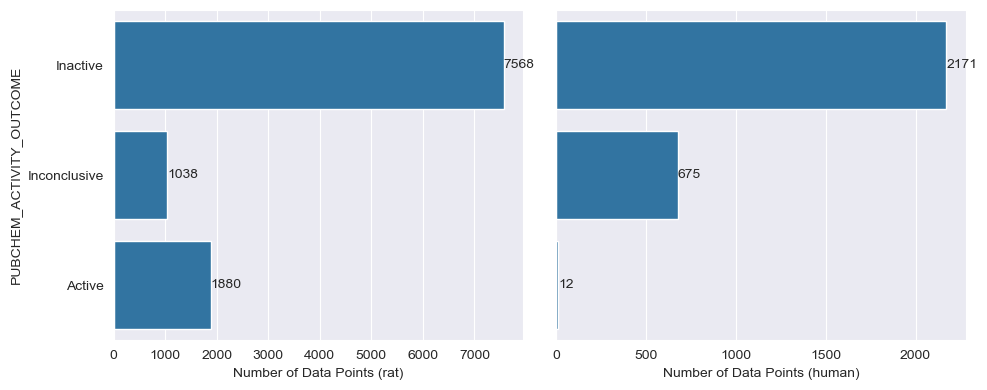

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
sns.countplot(data=df_aid_rat, y='PUBCHEM_ACTIVITY_OUTCOME', ax=axes[0])
sns.countplot(data=df_aid_human, y='PUBCHEM_ACTIVITY_OUTCOME', ax=axes[1])

axes[0].set_xlabel("Number of Data Points (rat)")
axes[1].set_xlabel("Number of Data Points (human)")

for ax in axes :    # loop over each chart.

    for container in ax.containers:
        ax.bar_label(container)

fig.tight_layout()

- The majority of the data points in the two data sets are declared in `Inactive`.
- There are 1880 `Active` data points in the rat data set and 12 `Active` data points in the human data set.

Both data sets have a column containing information on the observed characteristics of the chemicals tested in the assays.  These columns are:  

- `Phenotype-Replicate_1` for rats  
- `Phenotype` for humans  

It is worth mentioning that the column for rats is suffixed with `-Replicate_1`.  The rat data set contains data from repeated assay experiments, which are indicated as Replicate_1, Replicate_2, Replicate_3, and so on. For simplicity, we will use the data for `-Replicate_1`, but if we were to perform a stricter analysis, we should consider data from all replicates.

Now let's create two bar charts to compare the distribution of phenotypes ('Phenotype-Replicate_1' for rat and 'Phenotype' for human) across the two HTS datasets.

In [ ]:
# Write your own code


To find the relationship between the activity outcomes and phenotypes, let's count the occurrences of each unique combination of 'PUBCHEM_ACTIVITY_OUTCOME' and 'Phenotype-Replicate_1' in the **rat HTS data**.

In [38]:
df_aid_rat[['PUBCHEM_ACTIVITY_OUTCOME', 'Phenotype-Replicate_1' ]].value_counts()

PUBCHEM_ACTIVITY_OUTCOME  Phenotype-Replicate_1
Inactive                  Inactive                 7041
Active                    Inhibitor                1880
Inconclusive              Inhibitor                1038
Inactive                  Activator                 527
Name: count, dtype: int64

Now counts the occurrences of each unique combination of 'PUBCHEM_ACTIVITY_OUTCOME' and 'Phenotype' in the **human HTS data**.

In [39]:
df_aid_human[['PUBCHEM_ACTIVITY_OUTCOME', 'Phenotype' ]].value_counts()

PUBCHEM_ACTIVITY_OUTCOME  Phenotype   
Inactive                  Inactive        2171
Inconclusive              Inconclusive     451
                          Cytotoxic        132
                          Fluorescent       45
                          Inhibitor         31
                          Activator         16
Active                    Inhibitor         12
Name: count, dtype: int64

Get the same information using `.groupby()` and `.size()`

In [40]:
df_aid_human.groupby(by=['PUBCHEM_ACTIVITY_OUTCOME', 'Phenotype']).size()

PUBCHEM_ACTIVITY_OUTCOME  Phenotype   
Active                    Inhibitor         12
Inactive                  Inactive        2171
Inconclusive              Activator         16
                          Cytotoxic        132
                          Fluorescent       45
                          Inconclusive     451
                          Inhibitor         31
dtype: int64

There are several noteworthy things.

- The objective of the two assays considered here (i.e., [AID 743065](https://pubchem.ncbi.nlm.nih.gov/bioassay/743065) and [AID 588547](https://pubchem.ncbi.nlm.nih.gov/bioassay/588547)) was to identify antagonists (i.e., inhibitors) of thyroid hormone receptor.  With that said, the chemicals with the `Activitor` phenotype (i.e., agonist) are not declared as `Active` because the activator identification was not the objective of the assays.  They are declared as `Inactive` in the rat data set and as `Inconclusive` in the human data set. Note that the two assays are different experiments and whether to view activators as inactive or inconclusive is up to those who performed the experiment.
<br>  
- In the human data set, the compounds with the "inconclusive" outcomes have additional phenotypes, including Cytotoxic, Flurescent, Inconclusive, Inhibitor and Activator.
    - **cytotoxic**: some chemicals are so toxic that they kill cells.
    - **fluorescent**: some assays measure the activity of a chemical against the target protein by measuring the change in the fluorescence intensity caused by the protein-ligand interaction. However, some chemicals can absorb light energy and emit light through flourescence even without interaction with the target proteins.
    - inconclusive or inhibitor: some chemicals did not show a clear dose-response curve to compute the quantitative inhibitory activities (e.g., efficacy and potency), or did not show enough inhibitory activity.

#### Efficacy

In this section, we compare the **efficacy** data from the HTS assays for both rat and human thyroid hormone receptors.

First, let's generate two histograms to visualize and compare the distribution of efficacy values ('Efficacy-Replicate_1' for rat and 'Efficacy' for human) for different activity outcomes.

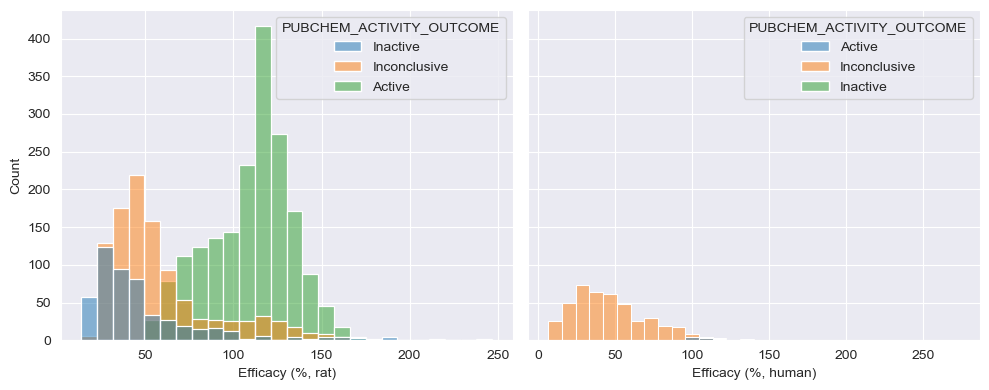

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)

sns.histplot(data=df_aid_rat, x='Efficacy-Replicate_1', hue='PUBCHEM_ACTIVITY_OUTCOME',ax=axes[0])
sns.histplot(data=df_aid_human, x='Efficacy', hue='PUBCHEM_ACTIVITY_OUTCOME', ax=axes[1])

axes[0].set_xlabel("Efficacy (%, rat)")
axes[1].set_xlabel("Efficacy (%, human)")

fig.tight_layout()

This time, visualize the same data using strip plot.

Text(0.5, 0, 'Efficacy (micro-M, human)')

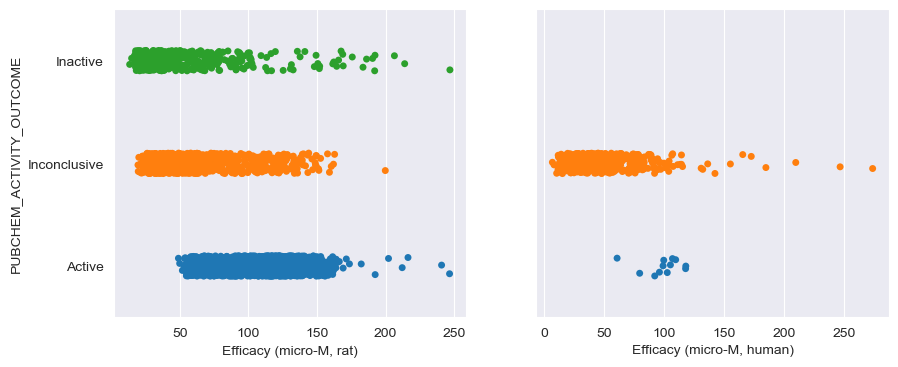

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)

hue_order = ['Active',  'Inconclusive', 'Inactive']

sns.stripplot(data=df_aid_rat, x='Efficacy-Replicate_1', y='PUBCHEM_ACTIVITY_OUTCOME', hue='PUBCHEM_ACTIVITY_OUTCOME', hue_order=hue_order, ax=axes[0])
sns.stripplot(data=df_aid_human, x='Efficacy', y='PUBCHEM_ACTIVITY_OUTCOME', hue='PUBCHEM_ACTIVITY_OUTCOME', hue_order=hue_order, ax=axes[1])

axes[0].set_xlabel("Efficacy (micro-M, rat)")
axes[1].set_xlabel("Efficacy (micro-M, human)")

You can use box plots to visualize the minimum, maximum, median, and outliers of the efficacy values.

Text(0.5, 0, 'Efficacy (micro-M, human)')

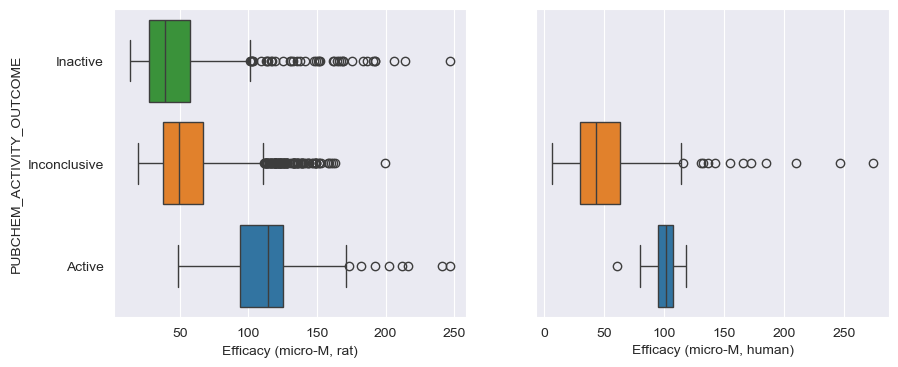

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)

hue_order = ['Active',  'Inconclusive', 'Inactive']

sns.boxplot(data=df_aid_rat, x='Efficacy-Replicate_1', y='PUBCHEM_ACTIVITY_OUTCOME', hue='PUBCHEM_ACTIVITY_OUTCOME', hue_order=hue_order, ax=axes[0])
sns.boxplot(data=df_aid_human, x='Efficacy', y='PUBCHEM_ACTIVITY_OUTCOME', hue='PUBCHEM_ACTIVITY_OUTCOME', hue_order=hue_order, ax=axes[1])

axes[0].set_xlabel("Efficacy (micro-M, rat)")
axes[1].set_xlabel("Efficacy (micro-M, human)")

The above histograms, strip plots, and box plots indicate that the assay against the **human** thyroid hormone receptor did not determine efficacy values for inactive compounds.

#### Potency

Now visualize the potency of the tested chemicals on the rat and human thyroid hormone receptors.

Generate two histograms to visualize and compare the distribution of potency values for different activity outcomes in the rat and human HTS datasets.

In [ ]:
# Write your own code


Generate two strip plots to visualize the potency values for different activity outcomes in the rat and human HTS datasets.

In [ ]:
# Write your own code


Generate two box plots to visualize the potency data for different activity outcomes in the rat and human HTS datasets.

In [ ]:
# Write your own code


Compute the mean, median, minimum, maximum of the efficacy and potency values for the different outcomes of the **rat** data set.

In [44]:
df_aid_rat.groupby('PUBCHEM_ACTIVITY_OUTCOME')[['Efficacy-Replicate_1', 'Potency-Replicate_1']].mean()

,Efficacy-Replicate_1,Potency-Replicate_1
PUBCHEM_ACTIVITY_OUTCOME,,
Active,110.130054,22.882127
Inactive,50.140904,27.487615
Inconclusive,58.654658,43.571585


In [45]:
df_aid_rat.groupby('PUBCHEM_ACTIVITY_OUTCOME')[['Efficacy-Replicate_1', 'Potency-Replicate_1']].median()

,Efficacy-Replicate_1,Potency-Replicate_1
PUBCHEM_ACTIVITY_OUTCOME,,
Active,113.98150,18.83360
Inactive,39.19415,24.44795
Inconclusive,49.11970,33.49150


In [46]:
df_aid_rat.groupby('PUBCHEM_ACTIVITY_OUTCOME')[['Efficacy-Replicate_1', 'Potency-Replicate_1']].min()

,Efficacy-Replicate_1,Potency-Replicate_1
PUBCHEM_ACTIVITY_OUTCOME,,
Active,49.0617,0.0007
Inactive,13.5294,0.0019
Inconclusive,19.5822,0.0033


In [47]:
df_aid_rat.groupby('PUBCHEM_ACTIVITY_OUTCOME')[['Efficacy-Replicate_1', 'Potency-Replicate_1']].max()

,Efficacy-Replicate_1,Potency-Replicate_1
PUBCHEM_ACTIVITY_OUTCOME,,
Active,246.592,159.683
Inactive,246.847,107.353
Inconclusive,199.769,343.762


Compute the mean, median, minimum, maximum of the efficacy and potency values for the different outcomes of the **human** data set.

In [ ]:
# Write your own code for mean


In [ ]:
# Write your own code for median


In [ ]:
# Write your own code for minimum


In [ ]:
# Write your own code for maximum


#### Efficacy vs Potency

This section explores the relationship between the efficacy and potency of the tested compounds for both the rat and human thyroid hormone receptors.


The following code creates two scatter plots, one for the rat data and one for the human data, to visualize the relationship between potency and efficacy, with points colored by their activity outcome.

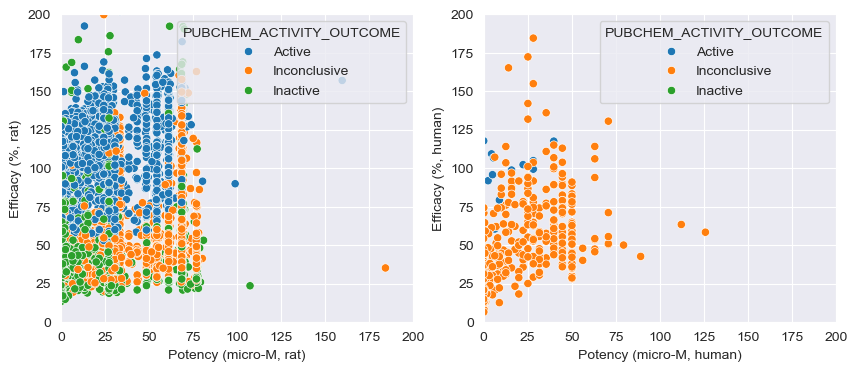

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=False)

hue_order = ['Active',  'Inconclusive', 'Inactive']

sns.scatterplot(data=df_aid_rat, x='Potency-Replicate_1', y='Efficacy-Replicate_1', hue='PUBCHEM_ACTIVITY_OUTCOME', hue_order=hue_order, ax=axes[0])
sns.scatterplot(data=df_aid_human, x='Potency', y='Efficacy', hue='PUBCHEM_ACTIVITY_OUTCOME', hue_order=hue_order, ax=axes[1])

axes[0].set_xlabel("Potency (micro-M, rat)")
axes[1].set_xlabel("Potency (micro-M, human)")

axes[0].set_ylabel("Efficacy (%, rat)")
axes[1].set_ylabel("Efficacy (%, human)")

# Uncomment next three lines to limit the x-axis to 200.
for ax in axes :    # loop over each panel
   ax.set_xlim(0, 200)
   ax.set_ylim(0, 200)

### Compound-level Analysis

In PubChem, substances are chemical records provided by individual data contributors and compounds are unique chemical structures extracted from substance records.  
In many assays, substances can be viewed as "samples" of chemicals.  A chemical can be tested in multiple samples containing that chemical in a single assay. The samples are not necessary the same as each other. For example, they may be different in terms of its concentration, temperature, solvent used, etc.  
Therefore, if you want to determine the activity of a chemical, you may need to collapse the data from multiple samples (i.e., substances) into a single data point for the chemical.  

The code cells below checks how many unique compounds in the data set and how many of them are associated with multiple substances.

In [50]:
df_rat_cidcount = pd.DataFrame(df_aid_rat['PUBCHEM_CID'].value_counts()).reset_index()
df_human_cidcount = pd.DataFrame(df_aid_human['PUBCHEM_CID'].value_counts()).reset_index()

In [51]:
print("#-- Rat data set")
print("# CIDs in total                      :", len(df_rat_cidcount) )
print("# CIDs associated with multiple SIDs :", len(df_rat_cidcount[df_rat_cidcount['count'] > 1]) )
print("------------------------------------------------")
print("#-- Human data set")
print("# CIDs in total                      :", len(df_human_cidcount) )
print("# CIDs associated with multiple SIDs :", len(df_human_cidcount[df_human_cidcount['count'] > 1]) )

#-- Rat data set
# CIDs in total                      : 8099
# CIDs associated with multiple SIDs : 1871
------------------------------------------------
#-- Human data set
# CIDs in total                      : 2325
# CIDs associated with multiple SIDs : 464


#### Aggregating substance data rats

Now we aggregate the substance data for each unique compound (identified by its CID).

This code groups the rat HTS data by 'PUBCHEM_CID' and store them in a data frame with three columns (`PUBCHEM_CID`, `Potency-Replicate_1`, and `Efficacy-Replicate_1`).  Note that some CIDs are associated with multiple SIDs, and hence, multiple activity values.  For those cases, we are going to take the average of the multiple activity values.

In [52]:
df_aid_rat_cid = df_aid_rat.groupby('PUBCHEM_CID').mean(numeric_only=True).reset_index()
df_aid_rat_cid = df_aid_rat_cid[['PUBCHEM_CID', 'Potency-Replicate_1', 'Efficacy-Replicate_1']]

In [53]:
df_aid_rat_cid.head()

,PUBCHEM_CID,Potency-Replicate_1,Efficacy-Replicate_1
0,4,NaN,NaN
1,6,4.6248,118.2025
2,11,NaN,NaN
3,13,NaN,NaN
4,33,NaN,NaN


This code defines a function, `get_cid_outcome`, that determines a single activity outcome for each unique compound ID (CID) in a given DataFrame. If a compound has multiple, conflicting outcomes recorded, it is labeled as "Conflicting".

In [54]:
def get_cid_outcome(df) :

    outcomes = {}

    for cid in df['PUBCHEM_CID'].dropna().unique() :   # loop over unique CIDs (without Null)

        outcome =""
    
        unique_outcomes = df[ df['PUBCHEM_CID'] == cid ]['PUBCHEM_ACTIVITY_OUTCOME'].unique()
    
        if ( len(unique_outcomes) == 1 ) :
            outcome = unique_outcomes[0]
        elif ( len(unique_outcomes) > 1 ) :
            outcome = "Conflicting"
        else :
            print("Warning: Something is wrong", cid, unique_outcomes)

        outcomes[ cid ] = outcome

    df_outcomes = pd.DataFrame.from_dict(outcomes, orient='index', columns=['PUBCHEM_ACTIVITY_OUTCOME']).reset_index(names='PUBCHEM_CID')

    return(df_outcomes)

This line of code applies the get_cid_outcome function to the rat HTS data to generate a DataFrame that summarizes the activity outcome for each unique compound.

In [55]:
df_cid_outcome_rat = get_cid_outcome(df_aid_rat)

In [56]:
df_cid_outcome_rat.head()

,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME
0,12850184,Inactive
1,89753,Inactive
2,9403,Inconclusive
3,13218779,Inactive
4,142766,Active


Now let's merge the aggregated rat compound data (containing mean potency and efficacy) with the summarized compound outcomes.

In [57]:
df_aid_rat_cid = df_aid_rat_cid.merge(df_cid_outcome_rat, on='PUBCHEM_CID', how='left')

In [58]:
df_aid_rat_cid.head()

,PUBCHEM_CID,Potency-Replicate_1,Efficacy-Replicate_1,PUBCHEM_ACTIVITY_OUTCOME
0,4,NaN,NaN,Inactive
1,6,4.6248,118.2025,Active
2,11,NaN,NaN,Inactive
3,13,NaN,NaN,Inactive
4,33,NaN,NaN,Inactive


This cell counts the occurrences of each unique 'PUBCHEM_ACTIVITY_OUTCOME' in the aggregated rat compound data.

In [59]:
df_aid_rat_cid['PUBCHEM_ACTIVITY_OUTCOME'].value_counts()

PUBCHEM_ACTIVITY_OUTCOME
Inactive        5745
Active          1383
Inconclusive     690
Conflicting      281
Name: count, dtype: int64

#### Aggregating substance data for humans

Now let's repeat the data aggregation process, this time for the human thyroid hormone receptor HTS data.

Group the human HTS data by 'PUBCHEM_CID' and store the mean efficacy and potency values in a data frame called 'df_aid_human_cid'.

In [62]:
df_aid_human_cid = df_aid_human.groupby('PUBCHEM_CID').mean(numeric_only=True).reset_index()
df_aid_human_cid = df_aid_human_cid[['PUBCHEM_CID', 'Potency', 'Efficacy']]

Show a first few line of the `df_aid_human_cid` data frame.

In [63]:
df_aid_human_cid.head()

,PUBCHEM_CID,Potency,Efficacy
0,6,70.7946,51.0835
1,11,NaN,NaN
2,13,NaN,NaN
3,51,NaN,NaN
4,66,17.7828,47.3640


Use the `get_cid_outcome` function to the human HTS data to generate a DataFrame that summarizes the activity outcome for each unique compound.

In [64]:
df_cid_outcome_human = get_cid_outcome(df_aid_human)

This command displays the first few rows of the DataFrame containing the summarized compound outcomes for the human data.

In [65]:
df_cid_outcome_human.head()

,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME
0,457193,Conflicting
1,15910,Active
2,443939,Active
3,62770,Active
4,8722,Conflicting


This code merges the aggregated human compound data with the summarized compound outcomes.

In [66]:
df_aid_human_cid = df_aid_human_cid.merge(df_cid_outcome_human, on="PUBCHEM_CID", how="left")

This command displays the first few rows of the merged human compound DataFrame.

In [67]:
df_aid_human_cid.head()

,PUBCHEM_CID,Potency,Efficacy,PUBCHEM_ACTIVITY_OUTCOME
0,6,70.7946,51.0835,Inconclusive
1,11,NaN,NaN,Inactive
2,13,NaN,NaN,Inactive
3,51,NaN,NaN,Inactive
4,66,17.7828,47.3640,Conflicting


Use `.value_counts()` the occurrences of each unique 'PUBCHEM_ACTIVITY_OUTCOME' in the aggregated human compound data.

In [68]:
df_aid_human_cid['PUBCHEM_ACTIVITY_OUTCOME'].value_counts()

PUBCHEM_ACTIVITY_OUTCOME
Inactive        1696
Inconclusive     477
Conflicting      144
Active             8
Name: count, dtype: int64

#### Merging rat data and human data

This subsection focuses on combining the aggregated compound-level data from both the rat and human HTS assays to facilitate a direct comparison.

This command displays the column names of the aggregated rat compound DataFrame.

In [70]:
df_aid_rat_cid.columns

Index(['PUBCHEM_CID', 'Potency-Replicate_1', 'Efficacy-Replicate_1',
       'PUBCHEM_ACTIVITY_OUTCOME'],
      dtype='object')

Let's rename the columns in the rat compound DataFrame to have consistent naming with the human compound DataFrame before merging.

In [71]:
df_aid_rat_cid = df_aid_rat_cid.rename(columns={'Potency-Replicate_1':'Potency' , 'Efficacy-Replicate_1':'Efficacy', })

This command displays the first three rows of the renamed rat compound DataFrame to verify the column name changes.

In [72]:
df_aid_rat_cid.head(3)

,PUBCHEM_CID,Potency,Efficacy,PUBCHEM_ACTIVITY_OUTCOME
0,4,NaN,NaN,Inactive
1,6,4.6248,118.2025,Active
2,11,NaN,NaN,Inactive


Now merge the aggregated rat and human compound DataFrames based on 'PUBCHEM_CID', keeping only the compounds that are present in both datasets.

In [73]:
df_aid_merged_cid = df_aid_rat_cid.merge(df_aid_human_cid, on='PUBCHEM_CID', how='inner', suffixes=('_rat','_human'))

Let's check if the merged data frame contains desired information.

In [74]:
df_aid_merged_cid.shape

(2089, 7)

In [75]:
df_aid_merged_cid

,PUBCHEM_CID,Potency_rat,Efficacy_rat,PUBCHEM_ACTIVITY_OUTCOME_rat,Potency_human,Efficacy_human,PUBCHEM_ACTIVITY_OUTCOME_human
0,6,4.6248,118.2025,Active,70.7946,51.0835,Inconclusive
1,11,NaN,NaN,Inactive,NaN,NaN,Inactive
2,13,NaN,NaN,Inactive,NaN,NaN,Inactive
3,51,NaN,NaN,Inactive,NaN,NaN,Inactive
4,66,0.4856,18.1479,Inactive,17.7828,47.3640,Conflicting
...,...,...,...,...,...,...,...
2084,135436526,60.7578,80.9324,Active,50.1187,57.0589,Inconclusive
2085,135465076,NaN,NaN,Inactive,0.1413,24.1825,Inconclusive
2086,135491830,NaN,NaN,Inactive,0.0025,54.4433,Inconclusive
2087,135492483,34.3762,42.1839,Inconclusive,NaN,NaN,Inactive


This cell counts the occurrences of each unique 'PUBCHEM_ACTIVITY_OUTCOME' for the rat data within the merged DataFrame.

In [76]:
df_aid_merged_cid['PUBCHEM_ACTIVITY_OUTCOME_rat'].value_counts()

PUBCHEM_ACTIVITY_OUTCOME_rat
Inactive        1473
Active           325
Conflicting      162
Inconclusive     129
Name: count, dtype: int64

This cell counts the occurrences of each unique 'PUBCHEM_ACTIVITY_OUTCOME' for the human data within the merged DataFrame.

In [77]:
df_aid_merged_cid['PUBCHEM_ACTIVITY_OUTCOME_human'].value_counts()

PUBCHEM_ACTIVITY_OUTCOME_human
Inactive        1540
Inconclusive     405
Conflicting      137
Active             7
Name: count, dtype: int64

#### Compound-level comparison

Let's compare the bioactivity of the same compounds between the rat and human thyroid hormone receptors.

The following code cell generates two box plots to compare the distribution of efficacy for different activity outcomes between the rat and human data in the merged dataset.

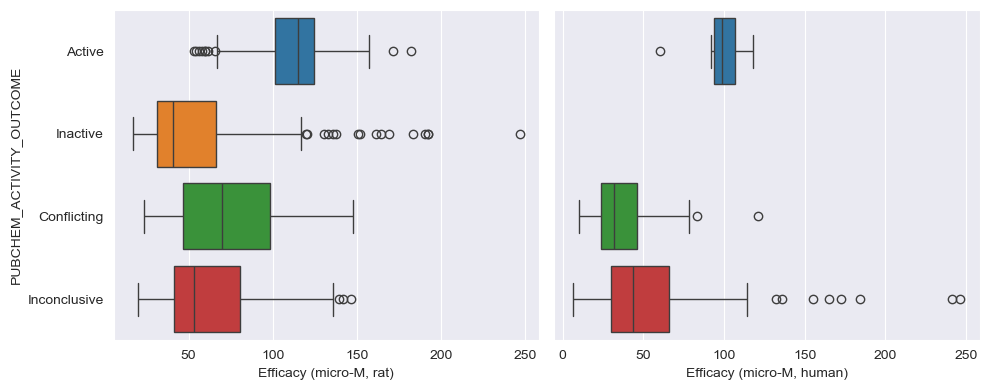

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)

hue_order = ['Active',  'Inactive', 'Conflicting', 'Inconclusive']

sns.boxplot(data=df_aid_merged_cid, x='Efficacy_rat', y='PUBCHEM_ACTIVITY_OUTCOME_rat', hue='PUBCHEM_ACTIVITY_OUTCOME_rat', hue_order=hue_order, ax=axes[0])
sns.boxplot(data=df_aid_merged_cid, x='Efficacy_human', y='PUBCHEM_ACTIVITY_OUTCOME_human', hue='PUBCHEM_ACTIVITY_OUTCOME_human', hue_order=hue_order, ax=axes[1])

axes[0].set_xlabel("Efficacy (micro-M, rat)")
axes[1].set_xlabel("Efficacy (micro-M, human)")

axes[0].set_ylabel("PUBCHEM_ACTIVITY_OUTCOME")

fig.tight_layout()

Generate two box plots to compare the distribution of potency for different activity outcomes between the rat and human data in the merged dataset.

In [ ]:
# Write your own code


This code creates two scatter plots to visualize the relationship between potency and efficacy for the rat and human data in the merged dataset.

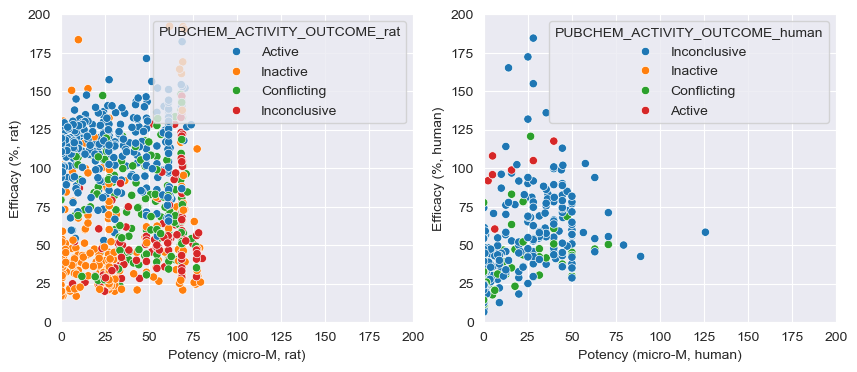

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=False)

#hue_order = ['Active',  'Inconclusive', 'Inactive']

sns.scatterplot(data=df_aid_merged_cid, x='Potency_rat', y='Efficacy_rat', hue='PUBCHEM_ACTIVITY_OUTCOME_rat', ax=axes[0])
sns.scatterplot(data=df_aid_merged_cid, x='Potency_human', y='Efficacy_human', hue='PUBCHEM_ACTIVITY_OUTCOME_human', ax=axes[1])

axes[0].set_xlabel("Potency (micro-M, rat)")
axes[1].set_xlabel("Potency (micro-M, human)")

axes[0].set_ylabel("Efficacy (%, rat)")
axes[1].set_ylabel("Efficacy (%, human)")

# Uncomment the next three lines to limit the x and y axes to 200.
for ax in axes :    # loop over each panel
   ax.set_xlim(0, 200)
   ax.set_ylim(0, 200)

This code creates two scatter plots to directly compare the efficacy and potency of compounds between the rat and human assays.

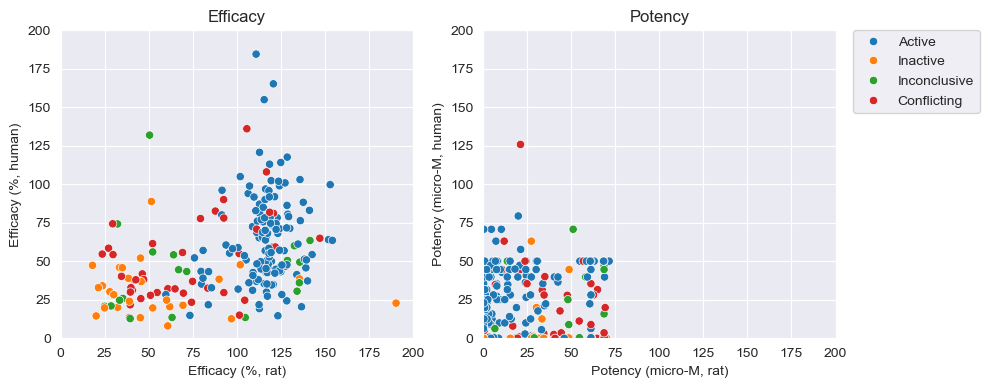

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=False)

hue_order = ['Active',  'Inactive', 'Inconclusive', 'Conflicting']

sns.scatterplot(data=df_aid_merged_cid, x='Efficacy_rat', y='Efficacy_human', hue='PUBCHEM_ACTIVITY_OUTCOME_rat', hue_order=hue_order, ax=axes[0], legend=None)
sns.scatterplot(data=df_aid_merged_cid, x='Potency_rat', y='Potency_human', hue='PUBCHEM_ACTIVITY_OUTCOME_rat', hue_order=hue_order, ax=axes[1])

axes[0].set_xlabel("Efficacy (%, rat)")
axes[0].set_ylabel("Efficacy (%, human)")
axes[0].set_title("Efficacy")

axes[1].set_xlabel("Potency (micro-M, rat)")
axes[1].set_ylabel("Potency (micro-M, human)")
axes[1].set_title("Potency")

axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Uncomment to limit the axes to 200.
for ax in axes :    # loop over each panel
  ax.set_xlim(0, 200)
  ax.set_ylim(0, 200)

In the above graphs, it is not easy to see if there is any correlation between rat and human activities (in terms of the efficacy and potency).

Let's focus only on the active compounds in both the rat and human assays.

In [ ]:
df_aid_merged_cid_active = df_aid_merged_cid[(df_aid_merged_cid['PUBCHEM_ACTIVITY_OUTCOME_rat'] == 'Active') & (df_aid_merged_cid['PUBCHEM_ACTIVITY_OUTCOME_human'] == 'Active')]

This code generates two scatter plots to compare the efficacy and potency of the compounds that were active in both rat and human assays.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=False)

sns.scatterplot(data=df_aid_merged_cid_active, x='Efficacy_rat', y='Efficacy_human', ax=axes[0])
sns.scatterplot(data=df_aid_merged_cid_active, x='Potency_rat', y='Potency_human', ax=axes[1])

axes[0].set_title("Efficacy")
axes[0].set_xlabel("Efficacy (%, rat)")
axes[0].set_ylabel("Efficacy (%, human)")

axes[1].set_title("Potency")
axes[1].set_xlabel("Potency (micro-M, rat)")
axes[1].set_ylabel("Potency (micro-M, human)")


In [ ]:
res_efficacy = linregress(df_aid_merged_cid_active['Efficacy_rat'], df_aid_merged_cid_active['Efficacy_human'])
res_potency = linregress(df_aid_merged_cid_active['Potency_rat'], df_aid_merged_cid_active['Potency_human'])

In [ ]:
print(f"                      Efficacy\tPotency")
print(f"Slope               : {res_efficacy.slope:4.4f}\t{res_potency.slope:<4.4f}")
print(f"intercept           : {res_efficacy.intercept:4.4f}\t{res_potency.intercept:4.4f}")
print(f"r-value             : {res_efficacy.rvalue:4.4f}\t{res_potency.rvalue:4.4f}")
print(f"p-value             : {res_efficacy.pvalue:4.4f}\t{res_potency.pvalue:4.4f}")
print(f"std-err (slope)     : {res_efficacy.stderr:4.4f}\t{res_potency.stderr:4.4f}")
print(f"std-err (intercept) : {res_efficacy.intercept_stderr:4.4f}\t{res_potency.intercept_stderr:4.4f}")

When we consider the compounds that are active in both species, there appears to be a positive correlation between the rat and human data.  However,  there are only six compounds active in both species, we cannot confidently say there is a definitive relationship.

## Discussion / Homework

1) Finalize the Pubchem script to pull data from PubChem for BOTH human and rats to avoid using the zipped files
2) Caclulate fingerprints for each of the CIDs examined in the final scatterplots. Write a script that looks for trends in similarity score and efficiacy or potency.

Further Reading:

**Limitations of Animal Studies for Predicting Toxicity in Clinical Trials: Is it Time to Rethink Our Current Approach?**  
Van Norman GA.  
JACC Basic Transl Sci. 2019 Nov 25;4(7):845-854.  
doi: [10.1016/j.jacbts.2019.10.008](https://doi.org/10.1016/j.jacbts.2019.10.008). PMID: 31998852; PMCID: PMC6978558.  
